In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
#os.chdir('C:\\Users\\Administrator\\Desktop\\Data\\AmazonFineFood\\database.sqlite')
os.chdir('C:\\Users\\prudi\\Desktop\\Data Sets\\amazon-fine-food-reviews')

In [2]:
con=sqlite3.connect('database.sqlite')
filtered_data=pd.read_sql_query("""select * from Reviews where Score!=3 LIMIT 2000""",con)

def partition(x):
    if x<3:
        return 0
    else:
        return 1
actualScore=filtered_data['Score']
partitionresult=actualScore.map(partition)
filtered_data['Score']=partitionresult
print("Number of data points in our data {shape} and rows {0}, columns {1}".format(filtered_data.shape[0],filtered_data.shape[1],shape=filtered_data.shape))

Number of data points in our data (2000, 10) and rows 2000, columns 10


In [3]:
display=pd.read_sql_query("""SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*) from Reviews group by UserId Having count(*)>1""",con)
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [4]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [5]:
display['COUNT(*)'].sum()

393063

## Data Cleaning

##### Deduplication

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [7]:
sorted_data=filtered_data.sort_values('ProductId',axis=0, ascending=True, inplace=False, kind='quicksort',na_position='last')


In [8]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first', inplace=False)
final.shape

(1998, 10)

In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final['Score'].value_counts()[0]

307

In [10]:
#Class Percentages
print('Class Distibusion of 1 is {one} and Class Distribution of 2 is {two}'.format(one=final['Score'].value_counts()[1]/(final['Score'].value_counts()[0]+final['Score'].value_counts()[1]),two=final['Score'].value_counts()[0]/(final['Score'].value_counts()[0]+final['Score'].value_counts()[1])))

Class Distibusion of 1 is 0.8463463463463463 and Class Distribution of 2 is 0.15365365365365366


In [11]:
sent_0=final['Text'].values[0]
print(sent_0)
print('='*50)

sent_500=final['Text'].values[500]
print(sent_500)
print('='*50)

sent_1000=final['Text'].values[1000]
print(sent_1000)
print('='*50)

sent_1500=final['Text'].values[1500]
print(sent_1500)
print('='*50)

I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.
Great service! Items arrived faster than expected. Very efficient! Will use this seller again. I highly recommend this seller! Thank you for the excellent service!
COULDN'T FIND THESE ANYWHERE BUT ON LINE - IT WAS WORTH THE WAIT BECAUSE THEY ARE TRULLY GREAT TASTING COOKIES.
These smell so good and are cute and a great size, with a bend in the middle to help roll, and holds together really well with tasty glue. Definitely recommend. Smell like strawberry bubble gum, doesn't really affect flavor too much, but better tha

In [12]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1071,1161,B000084E1U,A3DH85EYHW4AQH,Eric Hochman,1,1,1,1140739200,Cats love it!,I have nine cats and they are crazy about thes...
1331,1438,B0000VLH8S,APZ1KMTD4SNB9,C. Dembosky,2,2,1,1219968000,gold dust is awesome,This product allows me to make some really big...
1330,1437,B0000VLH8S,A3OX1UNG90U0G0,S. Woodcock,2,2,1,1229472000,shining star,i purchased this item for a cake that called f...


In [13]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_500 = re.sub(r"http\S+", "", sent_500)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_1500 = re.sub(r"http\S+", "", sent_1500)

print(sent_0)

I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.


In [14]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

I just received my shipment and could hardly wait to try this product. We love "slickers" which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.


In [15]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n't", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [17]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    #Removing the URL's
    sentance = re.sub(r"http\S+", "", sentance)
    # Removing the XML tags
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    # Function
    sentance = decontracted(sentance)
    # Removing digits
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    # Remvoing Special Characters
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:01<00:00, 1140.88it/s]


In [18]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews).toarray()
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.shape)
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.shape[1])

the type of count vectorizer  <class 'numpy.ndarray'>
the shape of out text BOW vectorizer  (1998, 1370)
the number of unique words including both unigrams and bigrams  1370


In [19]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=0.005)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews).toarray()
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.shape)
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.shape[1])

some sample features(unique words in the corpus) ['able', 'able find', 'absolute', 'absolutely', 'absolutely love', 'acid', 'across', 'actual', 'actually', 'add']
the type of count vectorizer  <class 'numpy.ndarray'>
the shape of out text TFIDF vectorizer  (1998, 1370)
the number of unique words including both unigrams and bigrams  1370


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(final_tf_idf,final['Score'],test_size=0.2,random_state=0)

### Word2Vec

In [21]:
list_of_sentance=[sentence.split() for sentence in preprocessed_reviews]

In [22]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True
import os
os.chdir('C:\\Users\\prudi\\Desktop\\Data Sets\\GoogleNews-vectors-negative300.bin')
#os.chdir('C:\\Users\\Administrator\\Desktop\\Data\\word2vec-GoogleNews-vectors-master\\word2vec-GoogleNews-vectors-master')

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('right', 0.9998712539672852), ('without', 0.9998535513877869), ('nothing', 0.9998493194580078), ('baked', 0.9998437762260437), ('really', 0.9998416900634766), ('nice', 0.9998371601104736), ('tasty', 0.9998365640640259), ('snack', 0.9998360872268677), ('far', 0.9998353719711304), ('texture', 0.9998335838317871)]
[('make', 0.9993650317192078), ('hand', 0.9993605613708496), ('breakfast', 0.9993568658828735), ('without', 0.9993501305580139), ('work', 0.9993472099304199), ('treat', 0.9993366003036499), ('packaged', 0.9993273019790649), ('coffee', 0.9993157386779785), ('must', 0.999315083026886), ('instant', 0.9993139505386353)]


In [23]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  2117
sample words  ['received', 'shipment', 'could', 'hardly', 'wait', 'try', 'product', 'love', 'call', 'instead', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'shop', 'going', 'lot', 'fun', 'everywhere', 'like', 'really', 'good', 'idea', 'outstanding', 'everybody', 'bought', 'made', 'two', 'cats', 'crazy', 'last', 'thing', 'want', 'cat', 'food', 'hate', 'buying', 'allows', 'make', 'big', 'spiced', 'nuts', 'fact', 'gold', 'little', 'show', 'people', 'amazed']


In [24]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:02<00:00, 771.72it/s]


1998
50


In [25]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [26]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:11<00:00, 167.44it/s]


<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [27]:
# Please write all the code with proper documentation

0.6877928105433688
0.9146008403361345


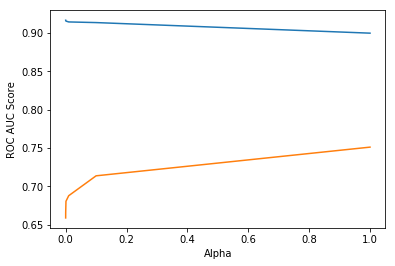

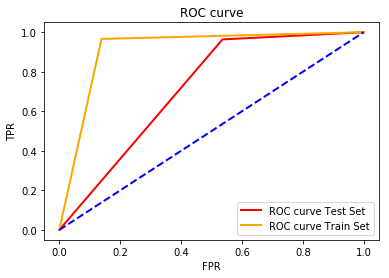

['love chips' 'eaten' 'cents' 'omaha' 'oils' 'office' 'offered'
 'not overly' 'not bitter' 'not big']
['disappointing' 'waste money' 'garbage' 'worst' 'edible' 'gross'
 'literally' 'msg' 'horrible' 'stay away']
    0    1
0  32   37
1  12  319


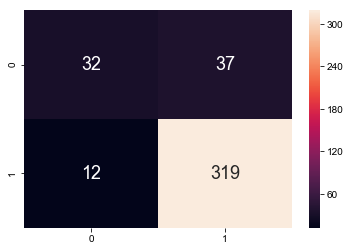

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(final_bigram_counts,final['Score'],test_size=0.2,random_state=0)

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
Multi_NB=MultinomialNB(alpha=0.01)
Multi_NB.fit(X_train,y_train)
y_pred=Multi_NB.predict(X_test)
print(roc_auc_score(y_test,y_pred))
y_pred=Multi_NB.predict(X_train)
print(roc_auc_score(y_train,y_pred))

## Grid Search
from sklearn.model_selection import GridSearchCV
parameters={'alpha':[ 0.00001,0.0001,0.001,0.01,0.1,1]}
clf=GridSearchCV(Multi_NB,parameters,cv=5)
clf.fit(X_train,y_train)
clf.predict(X_test)
clf.best_estimator_
clf.best_params_
clf.best_score_

## ROC AUC Curce
alpha=[0.00001,0.0001,0.001,0.01,0.1,1]
roc_score_train=[]
roc_score_test=[]
for i in alpha:
    Multi_NB=MultinomialNB(alpha=i)
    Multi_NB.fit(X_train,y_train)
    ## Test Dataset
    y_pred_test=Multi_NB.predict(X_test)
    roc_score_te=roc_auc_score(y_test,y_pred_test)
    roc_score_test.append(roc_score_te)
    ## Train Dataset
    y_pred_train=Multi_NB.predict(X_train)
    roc_score_tr=roc_auc_score(y_train,y_pred_train)
    roc_score_train.append(roc_score_tr)

plt.plot(alpha,roc_score_train)
plt.plot(alpha,roc_score_test)
plt.xticks()
#plt.legend()
plt.xlabel('Alpha')
plt.ylabel('ROC AUC Score')
plt.show()


## Plotting the ROC AUC Curve
from sklearn.metrics import roc_curve
Multi_NB=MultinomialNB(alpha=0.1)
Multi_NB.fit(X_train,y_train)
## Test Dataset
y_pred_test=Multi_NB.predict(X_test)
fpr,tpr,threshold=roc_curve(y_test,y_pred_test)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC curve Test Set')
y_pred_train=Multi_NB.predict(X_train)
fpr,tpr,threshold=roc_curve(y_train,y_pred_train)
plt.plot(fpr, tpr, color='orange',lw=2, label='ROC curve Train Set')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve')
plt.show()

neg_class_prob_sorted=Multi_NB.feature_log_prob_[0,:].argsort()
print(np.take(count_vect.get_feature_names(),neg_class_prob_sorted[:10]))

pos_class_prob_sorted=Multi_NB.feature_log_prob_[1,:].argsort()
print(np.take(count_vect.get_feature_names(),pos_class_prob_sorted[:10]))

from sklearn.metrics import confusion_matrix
cm_test=pd.DataFrame(confusion_matrix(y_test,y_pred_test))
print(cm_test)
sns.heatmap(cm_test, annot=True,annot_kws={"size": 18},fmt='g')
sns
sns.set(font_scale=1.4)

In [29]:
### TFIDF Dataset

In [30]:
tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews).toarray()
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.shape)
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.shape[1])

some sample features(unique words in the corpus) ['aahhhs', 'abates', 'abby', 'abdominal', 'abiding', 'ability', 'able', 'aboulutely', 'absence', 'absent']
the type of count vectorizer  <class 'numpy.ndarray'>
the shape of out text TFIDF vectorizer  (1998, 7976)
the number of unique words including both unigrams and bigrams  7976


### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(final_tf_idf,final['Score'],test_size=0.3,random_state=0)

In [32]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape

((1398, 7976), (1398,), (600, 7976), (600,))

0.6462872974339805
0.9678899082568807


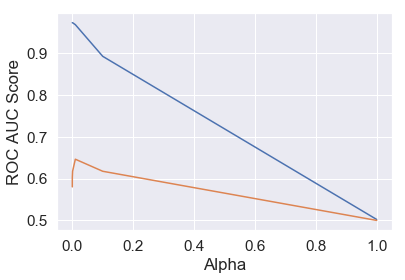

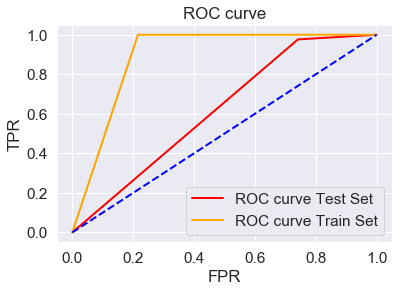

IndexError: index 3890 is out of bounds for axis 0 with size 1370

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(final_tf_idf,final['Score'],test_size=0.3,random_state=0)
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
Multi_NB=MultinomialNB(alpha=0.01)
Multi_NB.fit(X_train,y_train)
y_pred=Multi_NB.predict(X_test)
print(roc_auc_score(y_test,y_pred))
y_pred=Multi_NB.predict(X_train)
print(roc_auc_score(y_train,y_pred))

## Grid Search
from sklearn.model_selection import GridSearchCV
parameters={'alpha':[ 0.00001,0.0001,0.001,0.01,0.1,1]}
clf=GridSearchCV(Multi_NB,parameters,cv=5)
clf.fit(X_train,y_train)
clf.predict(X_test)
clf.best_estimator_
clf.best_params_
clf.best_score_

## ROC AUC Curce
alpha=[0.00001,0.0001,0.001,0.01,0.1,1]
roc_score_train=[]
roc_score_test=[]
for i in alpha:
    Multi_NB=MultinomialNB(alpha=i)
    Multi_NB.fit(X_train,y_train)
    ## Test Dataset
    y_pred_test=Multi_NB.predict(X_test)
    roc_score_te=roc_auc_score(y_test,y_pred_test)
    roc_score_test.append(roc_score_te)
    ## Train Dataset
    y_pred_train=Multi_NB.predict(X_train)
    roc_score_tr=roc_auc_score(y_train,y_pred_train)
    roc_score_train.append(roc_score_tr)

plt.plot(alpha,roc_score_train)
plt.plot(alpha,roc_score_test)
plt.xticks()
#plt.legend()
plt.xlabel('Alpha')
plt.ylabel('ROC AUC Score')
plt.show()


## Plotting the ROC AUC Curve
from sklearn.metrics import roc_curve
Multi_NB=MultinomialNB(alpha=0.1)
Multi_NB.fit(X_train,y_train)
## Test Dataset
y_pred_test=Multi_NB.predict(X_test)
fpr,tpr,threshold=roc_curve(y_test,y_pred_test)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC curve Test Set')
y_pred_train=Multi_NB.predict(X_train)
fpr,tpr,threshold=roc_curve(y_train,y_pred_train)
plt.plot(fpr, tpr, color='orange',lw=2, label='ROC curve Train Set')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC curve')
plt.show()

neg_class_prob_sorted=Multi_NB.feature_log_prob_[0,:].argsort()
print(np.take(count_vect.get_feature_names(),neg_class_prob_sorted[:10]))

pos_class_prob_sorted=Multi_NB.feature_log_prob_[1,:].argsort()
print(np.take(count_vect.get_feature_names(),pos_class_prob_sorted[:10]))

from sklearn.metrics import confusion_matrix
cm_test=pd.DataFrame(confusion_matrix(y_test,y_pred_test))
print(cm_test)
sns.heatmap(cm_test, annot=True,annot_kws={"size": 18},fmt='g')
sns
sns.set(font_scale=1.4)